# How to infer a landscape from observations of natural sequences

## Introduction to SeqDEFT

Many times, rather than quantitative measurements of a phenotype or trait for a large collection of sequences, we just have observations of natural sequences, e.g. 5' splice sites in the human transcriptome or combinations of chromosomal abnormalities in tumors (See [Chen et al. 2022](https://www.pnas.org/doi/10.1073/pnas.2025782118) for more details). In this case, we are interested in estimating the true underlying probability of each of the possible sequences using only a finite and typically small number of observations, that can range from few hundreds to tens or hundreds of thousands.

### Maximum entropy sequence probability distributions

A simple model would assume that positions are independent from each other, and thus, we can recapitulate the full sequence probability distribution from the site-wise allele probabilities. This is because if two positions are independent, then the probability of observing a particular combination at 2 sites is equal to the product of the individual probabilities at each site or, equivalently, the log-probability of the combination is the sum of the log-probabilities of the alleles at each position. 

$$p(AB) = p(A) p(B)$$

$$log(p(AB)) = log(p(A)) + log(p(B))$$

Thus, we can represent the probability of distribution of sequences of certain length using a field $\Phi$ as follows and show that the field is just a shifted version of the negative $\log Q$:

$$Q_i = \frac{e^{-\Phi_i}}{\sum_j e^{-\Phi_j}}$$

$$\log Q_i = -\Phi_i - \log\left({\sum_j e^{-\Phi_j}}\right) = -\Phi_i - C$$

Thus, independent sites models can be generally represented by additive models on the log-transformed probabilities. These models can be generalized by relaxing the assumption of additivity e.g. adding pairwise interaction terms like in the Potts model, which have been very succesful for contact prediction and identifying coevolving residues within or between different proteins and could be further extended to include up to $P$ order components. However, they all belong to the class of maximum entropy models, this is, they maximize the entropy while matching some statistics of the data e.g. allele frequencies at each site or frequencies of pairs of alleles, that are common across all sequences, thus completely neglecting interactions beyond the $P$th order

### Relaxing maximum entropy assumption: the $\Delta^{(P)}$ prior

SeqDEFT works relaxes the maximum entropy assumption by instead minimizing the magnitude of the deviations in the field $\Phi$ from the additive, pairwise, or in general, $P-1$ order model across all $P$-faces of the Hamming hypercube. The strength of this penalization is given by the hyperparameter $a$. This is equivalent to imposing a normal prior on the the local P-epistatic coefficients $\epsilon$'s while conditioning on being compatible with each other. In particular, for $P=2$, we minimize the local deviations from a simple additive model or local pairwise epistatic coefficients $\epsilon$. 

$$\epsilon = (\Phi_{11} - \Phi_{10}) - (\Phi_{01} - \Phi_{00}) = \Phi_{11} + \Phi_{00} - \Phi_{01} - \Phi_{10}$$

In this case, we are setting a normal prior on the local pairwise epistatic coefficients, where the variance is inversely related to the hyperparameter $a$, where $\kappa$ is the dimension of the the unpenalized space comprising up to $P-1$th order interactions, $\alpha$ the number of alleles and $\ell$ the sequence length.

$$\epsilon \sim Normal\left(0, \sigma^2\right)$$
$$\sigma^2 = \frac{\alpha^\ell-\kappa}{a}$$

Note that this allows the $P$-epistatic coefficients to differ across distinct genetic backgrounds in a controled manner, allowing higher order interactions in regions of sequence space where there is strong evidence for them but being closer to the maximum entropy model in regions of sequence space where the data is more scarce.

### The likelihood

Our model assumes a multinomial likelihood with $\alpha^\ell$ categories corresponding to all possible sequences of length $\ell$ with $\alpha$ alleles given a total number of observations $N$.

$$n \sim Multinomial(N, Q)$$

This implies that each observation of a sequence is completely independently every other in the collection of observed sequences, an assumption that is sometimes violated in nature e.g. due to common ancestry or phylogenetic relationships.

### Hyperparameter optimization

We optimize $a$ using cross-validation and select the $a^*$ with the highest log-likelihood in held out data. In practice, we need to define a finite series of $a$ values, which we know interpolate between the maximum entropy solution of order $P$ (where all these deviations are exactly 0) and the observed empirical frequencies for each of the sequences, which are subject to sampling noise. Thus, in practice, we are smoothing the $\log Q$ over sequence space, where $a*$ indicates the degree of the smoothing between these two extreme cases. 

Thus, we generate a geometrically spaced series of $a$ values between a minimal $a$ value that is very close to the empirical frequencies and maximum $a$ value that is very close to the maximum entropy solution, assuming that the best solution will be somewhere in the middle, with some contribution of the local deviations from the $P-1$th order model.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.special._logsumexp import logsumexp
from scipy.stats.stats import pearsonr

import gpmap.src.plot as plot

from gpmap.src.inference import SeqDEFT
from gpmap.src.seq import calc_msa_weights, get_subsequences
from gpmap.src.space import SequenceSpace
from gpmap.src.randwalk import WMWalk
from gpmap.src.datasets import DataSet

## Simulating data from the prior distribution

For illustration purposes, lets first sample a complete landscape by generating a sequence probability distribution from the prior distribution characterzed by `a=500` and `P=2`. 

In [2]:
np.random.seed(1)
model = SeqDEFT(P=2)
model.init(seq_length=5, alphabet_type='dna')
phi = model.simulate_phi(a=500)

We will assume that the simulated values are the $\Phi$ values for each sequence and then sample a small number of observations from the resulting probability distribution and show the values for some of the sequences.

In [3]:
X = model.simulate(N=1000, phi=phi)
X_unique, counts = np.unique(X, return_counts=True)
print("{:.2f} % of possible genotypes observed at least once".format(X_unique.shape[0] / model.n_genotypes * 100))

50.29 % of possible genotypes observed at least once


[Text(0.5, 0, '# time a sequence is observed'),
 Text(0, 0.5, '# unique sequences')]

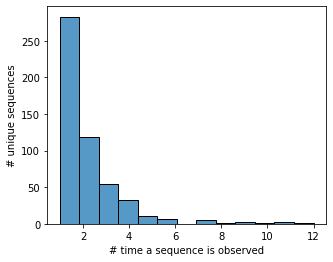

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(5, 4))
sns.histplot(counts, ax=axes, bins=max(counts)+1)
axes.set(xlabel='# time a sequence is observed', ylabel='# unique sequences')

Note that about half of the possible sequences are not even observed once when sampling up to 1000 sequences, and only very few are observed more than once. While this evidences that their probability is probably lower than the highly observed sequences, there is still a wide range of variability in the sequence probability below the observable threshold that we may be able to infer by sharing information across sequence space.

## Inference of the underlying probability distribution

Lets initialize again our SeqDEFT model with `P=2` and infer the sequence probability distribution underlying the finite set of observed sequences in nature

In [5]:
model = SeqDEFT(P=2)
inferred = model.fit(X=X)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:04<00:00, 25.55it/s]
/home/martigo/miniconda3/envs/gpmap/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


We can see that even for a small example of 5 nucleotides long sequence spanning only $4^5=1024$ possible genotypes, iterating through all the cross-validation folds for each $a$ value takes a substatial amount of time. For larger genotypic spaces, however, one could paralellize these calculations by defining the training and testing datasets for the cross-validation and fit the model with different $a$ values at the same time.

Lets see how the log-likelihood in held-out data evolves with the different values of the hyperparameter $a$ tested.

In [6]:
model.logL_df

,a,fold,logL,log_a,sd,log_sd
0,0.000000e+00,0,-inf,-inf,inf,inf
1,2.304000e-02,0,-2151.013057,-1.637518,1000.000000,3.000000
2,4.767294e-02,0,-2093.956063,-1.321728,695.192796,2.842105
3,9.864190e-02,0,-2040.896007,-1.005939,483.293024,2.684211
4,2.041037e-01,0,-1986.952495,-0.690149,335.981829,2.526316
...,...,...,...,...,...,...
105,2.600843e+03,4,-1562.622290,3.415114,2.976351,0.473684
106,5.381502e+03,4,-1571.766715,3.730904,2.069138,0.315789
107,1.113507e+04,4,-1578.399913,4.046693,1.438450,0.157895
108,2.304000e+04,4,-1582.322149,4.362482,1.000000,0.000000


In [7]:
print('a*={}'.format(model.a))

a*=607.4843670674737


/home/martigo/miniconda3/envs/gpmap/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


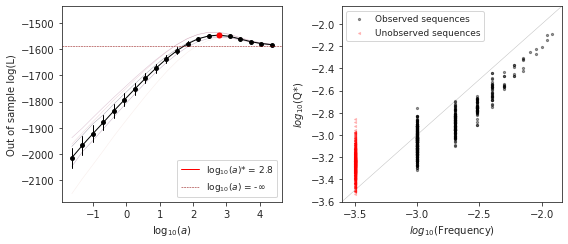

In [8]:
fig = plot.plot_SeqDEFT_summary(model.logL_df, inferred, legend_loc=4)

 We can see that the optimal value $a^*$ is far from 0 but also is not $\infty$ either and close to the true generating $a_{True}=500$, showing that the optimal solution is indeed somewhere in between the maximum entropy solution and the empirical frequencies. In this case, we chose $a$ to have relatively small deviation from the additive model, so that the cross-validated likelihood in the case $a=\infty$ is close to that under $a^*$

The second plot shows the relationship between the observed frequencies in the data and the inferred probabilities for each of the genotypes. For high frequencies, we generally see a very good agreement between the observed frequencies and inferred probabilities. However, as we start to have lower number of counts per sequence, we can see how the prior becomes more and more important. In fact, the sequences with lowest frequency, those never observed or only once, show substantial variability in the inferred densities thanks to our ability to share information across neighboring sequences and smooth the log-probabilities over sequence space.

Note that we are also plotting sequences with 0-counts in red and with a different marker at an arbitrary position in the x-axis. We can see that the inferred probabilities are in average lower than for those sequences with 1 count, but both sets of sequences show a large spread when compared to that difference. This means that, at least in this case, observing a sequence alone does not provide such a strong evidence of functionality as compared with unobserved sequences. 

## Evaluating the inferred probability distributions

In this case, as the data was simulated, we can see good our estimates of the sequence density were by comparing with the true data generating probabilities

In [9]:
inferred['Q_true'] = np.exp(- phi - logsumexp(phi))
inferred

,frequency,Q_star,Q_true
AAAAA,0.000,0.000705,0.000265
AAAAC,0.001,0.001267,0.001562
AAAAG,0.001,0.000796,0.000765
AAAAT,0.004,0.002822,0.003109
AAACA,0.002,0.001375,0.000515
...,...,...,...
TTTGT,0.000,0.000835,0.003168
TTTTA,0.000,0.001403,0.001943
TTTTC,0.001,0.001481,0.001309
TTTTG,0.003,0.001746,0.000687


Text(0.0015, 2e-05, 'Pearson r=0.69')

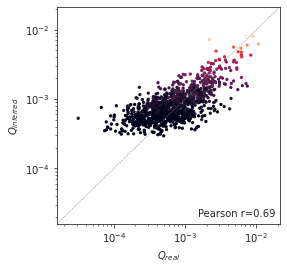

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4), sharex=True, sharey=True)

Q = inferred[['Q_true', 'Q_star']].values.flatten()
lims = (Q.min()/2, Q.max()*2)
axes.scatter(inferred['Q_true'], inferred['Q_star'], s=5, c=inferred['frequency'])
axes.plot(lims, lims, lw=0.5, linestyle='--', c='grey')
axes.set(xlabel=r'$Q_{real}$', ylabel=r'$Q_{inferred}$',
         xscale='log', yscale='log',
         xlim=lims, ylim=lims)

r = pearsonr(np.log(inferred['Q_true']), np.log(inferred['Q_star']))[0]
axes.text(1.5e-3, 2e-5, 'Pearson r={:.2f}'.format(r))

We can see that even for sequences with low density, such that they  would almost never be observed in practice by sampling only 1000 genotypes from this distribution, SeqDEFT provides a moderately good estimate of the sequence density. While it tends to overestimate the density of very rare sequences, it still provides a good idea of which sequences have higher or lower probability.

## Main features of the probability distribution are preserved

But maybe a more important issue rather than the precission with which we can estimate the sequence probability is whether we are able to recover the main qualitative features of the original landscape from the simulated data. Thus, we can compare the visualizations for both the real and the estimated $\log Q$ as follows:

In [11]:
space_real = SequenceSpace(X=inferred.index.values, y=np.log10(inferred['Q_true']))
space_inferred = SequenceSpace(X=inferred.index.values, y=np.log10(inferred['Q_star']))
spaces = {'real': space_real, 'inferred': space_inferred}

### How to choose Ns when visualizing a sequence probability distribution

When trying to visualize densities rather than an arbitrary function or phenotype over sequence space, it provides a very natural way of setting the hyperparameter ``Ns``, since we can assume that the observed densities correspond to the stationary frequencies under our evolutionary model. As we saw previously, the stationary frequencies are given by:

$$\pi_i = \frac{e^{Ns f_i}}{\sum_j e^{Ns f_j}}$$

Thus, if we assume that $f_i = \log Q_i$, then we can choose ``Ns=1`` and:

$$\pi_i = \frac{e^{\log Q_i}}{\sum_j e^{\log Q_j}} = Q_i$$


In [12]:
viz = {}
for label, space in spaces.items():
    rw = WMWalk(space)
    rw.calc_visualization(Ns=1, n_components=5)
    nodes_df, edges_df = rw.nodes_df, rw.space.get_edges_df()
    viz[label] = nodes_df, edges_df

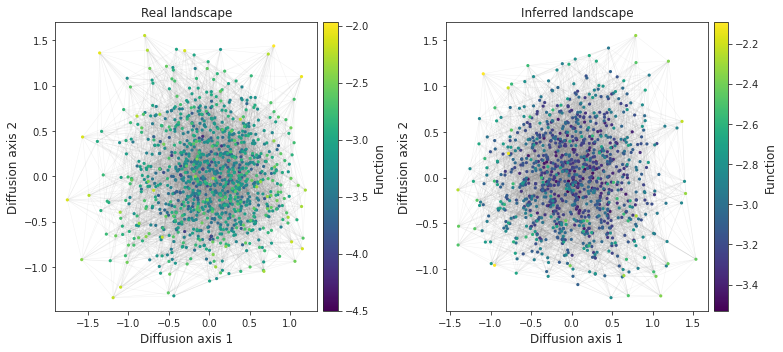

In [13]:
fig, subplots = plot.init_fig(1, len(spaces), colsize=5.5, rowsize=5)

for axes, (label, (nodes_df, edges_df)) in zip(subplots, viz.items()):
    plot.plot_visualization(axes, nodes_df, edges_df=edges_df, nodes_size=10)
    axes.set_title('{} landscape'.format(label.capitalize()))

fig.tight_layout()

It seems that the structure of the two landscapes is similar, but it is unclear from the plots whether the most separated set of sequences are the same in the two plots. We can instead show how the coordinates in the different diffusion axis correlate across the two embeddings

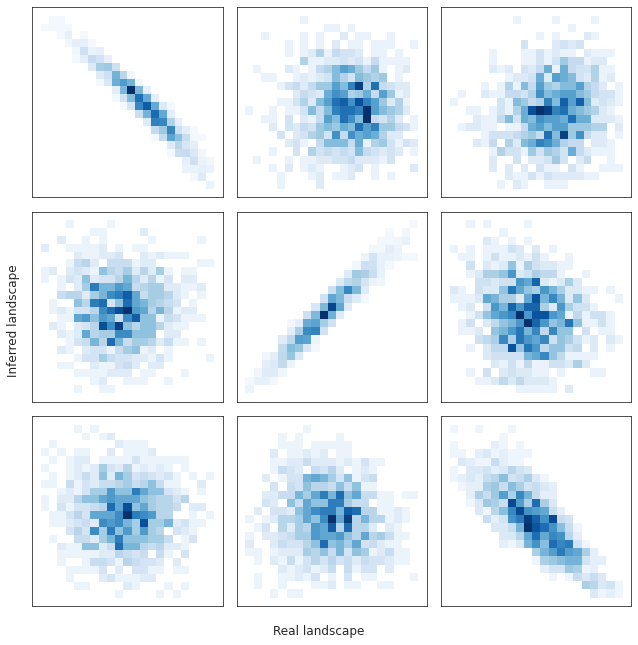

In [14]:
fig, subplots = plot.init_fig(3, 3, colsize=3, rowsize=3)

for i in range(3):
    for j in range(3):
        axes = subplots[i, j]
        x, y = viz['real'][0][str(i+1)].values, viz['inferred'][0][str(j+1)].values
        sns.histplot(x=x, y=y, cmap='Blues', ax=axes)
        axes.set(xlabel='', ylabel='', xticks=[], yticks=[])

fig.supxlabel('Real landscape')
fig.supylabel('Inferred landscape')
fig.tight_layout()

Thus, we can see that the main structure is preserved, with a very good correlation in the coordinates of the main diffusion axes between the real and inferred sequence densities.

## How to deal with phylogenetically related observations

One of the key assumptions of the original SeqDEFT method is that observations of sequences are completely independent from each other. While this assumption may be reasonable for regulatory elements spread along the genome that have been evolving independently from each other for a long time, such as the 5' splice site or transcription factor binding sites, it is not the case when we are dealing with multiple sequence alignments of homologous proteins across different species.

This is a well known issue in pairwise models, including Potts models used for Direct Coupling Analysis (DCA) and is generally dealt with by re-weighting the observed sequences such that sequences that are closely related to each other take smaller weights. See [Hockenberry and Wilke 2019](https://www.mdpi.com/1099-4300/21/10/1000) for more information. 

### How to use pre-defined weights from phylogenetic correction

We have implemented the same correction and allow user-defined weights for each of the sequences through the `y` argument using the full length sequences, from which we only select a subset of positions for inference.

In [15]:
positions = np.arange(3)
y = calc_msa_weights(X, phylo_correction=True)
output = model.fit(X=get_subsequences(X, positions=positions), y=y)
output

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:01<00:00, 103.98it/s]
/home/martigo/miniconda3/envs/gpmap/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,frequency,Q_star
AAA,0.019417,0.015545
AAC,0.017476,0.013479
AAG,0.015534,0.012936
AAT,0.011650,0.014023
ACA,0.017476,0.015059
...,...,...
TGT,0.009709,0.014053
TTA,0.025243,0.018564
TTC,0.021359,0.016097
TTG,0.017476,0.015448


### How to account for phylogenetic correction during cross-validation

The previous approach allows to have arbitrary weights obtained from any other external means, but variability in the reweighting scheme is not taken into account during cross validation. We can apply the correction separately to training and validation sets by including the full length sequence as input and specifying the positions to take into account and activating the phylogenetic correction option as follows

In [16]:
model.fit(X=X, phylo_correction=True, positions=positions)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:01<00:00, 90.84it/s]
/home/martigo/miniconda3/envs/gpmap/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,frequency,Q_star
AAA,0.019417,0.015545
AAC,0.017476,0.013479
AAG,0.015534,0.012936
AAT,0.011650,0.014023
ACA,0.017476,0.015059
...,...,...
TGT,0.009709,0.014053
TTA,0.025243,0.018564
TTC,0.021359,0.016097
TTG,0.017476,0.015448


Whether the correction is applied before or after splitting the data only has a influence when choosing $a*$ to use with the full data and does not have a strong effect in our experience.

## How to infer the 5'splice site probability distribution in the human genome

In the previous sections, we have showed how to run SeqDEFT on a small simulated dataset where the true underlying probability distribution is perfectly known. Next, we will show how to run in on a larger dataset and how to reproduce the inference and visualization performed in the original publication ([Chen et al. 2022](https://www.pnas.org/doi/10.1073/pnas.2025782118)) using the set of 5'splice sites extracted from the human genome.

In [17]:
ss = DataSet('5ss')
ss.data

,X
0,AAAAAAAAAA
1,AAAAAAAAAA
2,AAAAAAAAAA
3,AAAAAAAAAT
4,AAAAAAAATT
...,...
305101,TTTTTTTTTT
305102,TTTTTTTTTT
305103,TTTTTTTTTT
305104,TTTTTTTTTT


We can see that there is a large number of observations along the human genome. Previous efforts have used pairwise Maximum Entropy models to characterize the splice sites probability distributions along the genome ([Yeo and Burge (2004)](https://pubmed.ncbi.nlm.nih.gov/15285897/)). In what follows, we relax the constrains of this pairwise model to allow variability in the local pairwise epistatic coefficients by specifying `P=2`.

To reduce the computational burden and for simplicity, we select the sequences that have the cannonical GU at positions +1 and +2 and investigate the dependencies on the other positions: -3 to -1 together with +3 to +6.

In [18]:
X = np.array([seq[1:4] + seq[6:] for seq in ss.data.X if seq[4:6] == 'GT'])
X

array(['AAAAAAA', 'AAAAAAA', 'AAAAAAA', ..., 'TTTTTTG', 'TTTTTTT',
       'TTTTTTT'], dtype='<U7')

In [19]:
model = SeqDEFT(P=2)
inferred = model.fit(X=X)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [05:27<00:00,  2.98s/it]
/home/martigo/miniconda3/envs/gpmap/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Note that fitting the model for a dataset this large takes a long time. For illustration purposes, we can use the estimated probability distribution from the built-in dataset

In [20]:
inferred

,frequency,Q_star
AAAAAAA,0.000129,1.232180e-04
AAAAAAC,0.000058,5.626331e-05
AAAAAAG,0.000133,1.290231e-04
AAAAAAT,0.000272,2.705106e-04
AAAAACA,0.000017,1.872067e-05
...,...,...
TTTTTGT,0.000010,7.255876e-06
TTTTTTA,0.000014,1.178202e-06
TTTTTTC,0.000000,3.800720e-07
TTTTTTG,0.000003,5.042378e-07


/home/martigo/miniconda3/envs/gpmap/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


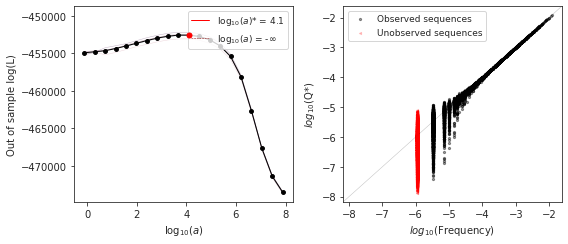

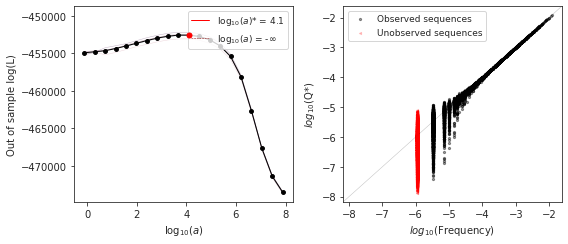

In [21]:
plot.plot_SeqDEFT_summary(model.logL_df, inferred, show_folds=True)

We can see how the probability of sequences that have been observed a fair number of times matches their frequency in the dataset, but there is a large variation, of several orders of magnitude in the probability of sequences that have been observed only a few times in the dataset or none at all, as highlithed in red

### Visualizing the 5'ss probability distribution

In [22]:
space = SequenceSpace(X=inferred.index.values, y=np.log(inferred['Q_star']))
print(space)

Sequence Space:
	Type: dna
	Sequence length: 7
	Number of alleles per site: [4, 4, 4, 4, 4, 4, 4]
	Genotypes: [AAAAAAA,AAAAAAC,AAAAAAG,...,TTTTTTC,TTTTTTG,TTTTTTT]
	Function y: [-9.00,-9.79,-8.96,...,-14.78,-14.50,-12.75]


In [23]:
rw = WMWalk(space)
rw.calc_visualization(Ns=1)
ndf, edf = rw.nodes_df, space.get_edges_df()
ndf['2'] = -ndf['2']
ndf['1'] = -ndf['1']
ndf.index = np.array([seq[:3] + 'GT' + seq[3:] for seq in ndf.index])

After generating the coordinates of the visualization and re-inserting the GT sequence at +1 and +2, we can plot the resulting landscape and highlight the sequences that were previously reported to characterize qualitatively different solutions to the 5'splice site recognition ([Chen et al. 2022](https://www.pnas.org/doi/10.1073/pnas.2025782118))

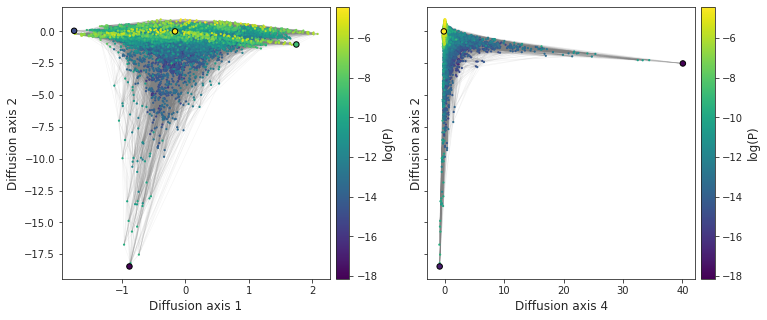

In [24]:
fig, subplots = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

axes = subplots[0]
plot.plot_visualization(axes, ndf, edges_df=edf, nodes_size=5,
                        nodes_cmap_label='log(P)')
seqs = ['CAGGTTCAA', 'CAGGTAAGT', 'TCTGTAAGT',
        'ACTGTATCC']
plot.plot_nodes(axes, ndf.loc[seqs, :], size=30, lw=1, edgecolor='black', cbar=False)

axes = subplots[1]
plot.plot_visualization(axes, ndf, edges_df=edf, nodes_size=5, x='4',
                        nodes_cmap_label='log(P)')
seqs = ['CAGGTAAGT', 'ACTGTATCC',
        'ACAGTTAAG']
plot.plot_nodes(axes, ndf.loc[seqs, :], size=30, lw=1, edgecolor='black', cbar=False, x='4')